In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from src.imagenet_x import get_factor_accuracies, error_ratio
from src.imagenet_x.utils import load_model_predictions, get_annotation_path
from src.imagenet_x import plots
from src.imagenet_x.evaluate import ImageNetX, get_vanilla_transform, ImageNetXImageFolder, load_annotations
import matplotlib.ticker as mtick
import os
import pickle
from pathlib import Path

In [108]:
df1 = pd.read_csv('../metalabel_objectivity/val_imgs_df.csv')

In [109]:
df1

,file_name,multiple_objects,background,color,brighter,darker,style,larger,smaller,object_blocking,...,partial_view,pattern,pose,shape,subcategory,texture,justification,one_word,label,str_label
0,ILSVRC2012_val_00004487.JPEG,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,close up of a pan fried sea bass.,sea bass close up,762,restaurant
1,ILSVRC2012_val_00003963.JPEG,0,1,1,0,0,1,0,0,0,...,0,0,1,0,0,0,sepia image of tiger,digitally altered,292,tiger
2,ILSVRC2012_val_00041992.JPEG,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,the bridge is brown,rare view,718,pier
3,ILSVRC2012_val_00028056.JPEG,0,1,0,0,0,0,0,0,0,...,0,1,1,1,0,0,the magnetic compass is on the bronze container,wood shape,635,magnetic compass
4,ILSVRC2012_val_00016832.JPEG,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,A dark image of a church.,dark,497,church
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48863,ILSVRC2012_val_00004973.JPEG,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,color is different,color,973,coral reef
48864,ILSVRC2012_val_00038750.JPEG,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,front view image of rocking chair made by digi...,window digital art,765,rocking chair
48865,ILSVRC2012_val_00043497.JPEG,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,right angle of analog clock with gold metallic...,right angle,409,analog clock
48866,ILSVRC2012_val_00005859.JPEG,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,A different design of a beer glass.,pattern background,441,beer glass


In [54]:
df2 = df1.groupby('str_label').mean(numeric_only=True).drop('label', axis=1)

In [110]:
df2['multiple objects'] = df2['multiple_objects']
df2['object blocking'] = df2['object_blocking']
df2['partial view'] = df2['partial_view']
df2['person blocking'] = df2['person_blocking']

In [111]:
split1 = df2[['pose','background', 'color', 'pattern']]
split2 = df2[['multiple objects','smaller', 'shape', 'subcategory']]
split3 = df2[['darker','style','texture','partial view']]
split4 = df2[['brighter','larger','object blocking', 'person blocking']]

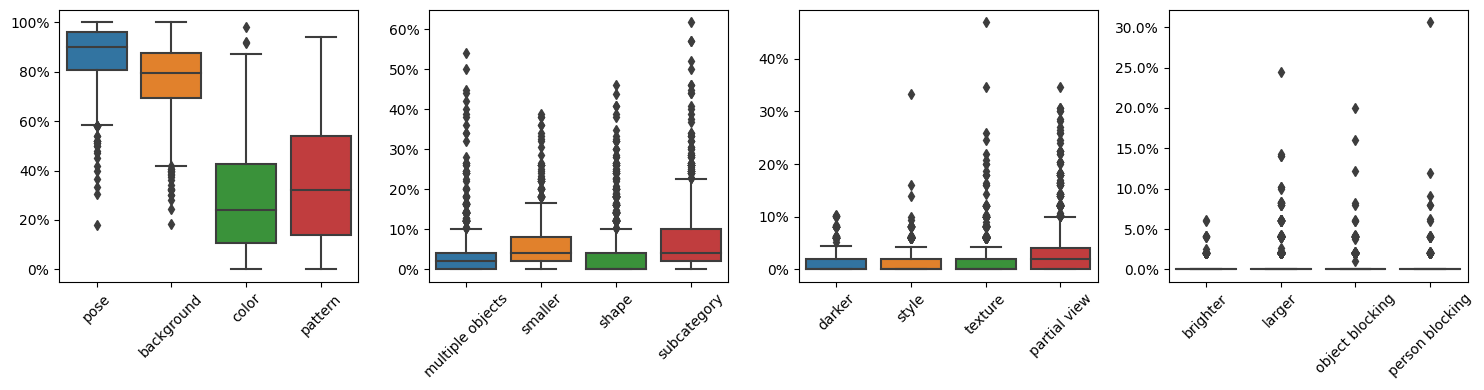

In [116]:
fig, ax = plt.subplots(1,4, figsize=(15, 4))
ax[0].tick_params(axis='x', rotation=45)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].tick_params(axis='x', rotation=45)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[2].tick_params(axis='x', rotation=45)
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[3].tick_params(axis='x', rotation=45)
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
sns.boxplot(data=split1, ax=ax[0])
sns.boxplot(data=split2, ax=ax[1])
sns.boxplot(data=split3, ax=ax[2])

sns.boxplot(data=split4, ax=ax[3])
fig.tight_layout()
plt.show()

In [20]:
df3 = df2 / df2.mean()

In [22]:
df3.max()

multiple_objects     14.191088
background            1.299027
color                 3.493485
brighter             31.345697
darker                9.820744
style                25.510155
larger               29.513015
smaller               6.498809
object_blocking      45.409257
person_blocking     136.232332
partial_view         10.688419
pattern               2.718275
pose                  1.149742
shape                11.575409
subcategory           8.059878
texture              25.541362
label                 2.001465
dtype: float64

In [25]:
df3[df3['texture'] > 25]

,multiple_objects,background,color,brighter,darker,style,larger,smaller,object_blocking,person_blocking,partial_view,pattern,pose,shape,subcategory,texture,label
str_label,,,,,,,,,,,,,,,,,
shopping basket,0.0,1.113452,2.473521,0.0,0.0,0.0,0.0,1.026128,0.0,0.0,2.514922,2.537687,0.938565,3.594847,2.665829,25.541362,1.58274


In [27]:
total = 2467.5
jul = 0.205
jon = 0.205
chris = 0.205
bruun = 0.205
malle = 0.18
print(jul + jon + chris + bruun + malle)

print(total)
print('Julius', jul * total)
print('Jonna', jon * total)
print('Chris', chris * total)
print('Bruun', bruun * total)
print('Malle', malle * total)



1.0
2467.5
Julius 505.8375
Jonna 505.8375
Chris 505.8375
Bruun 505.8375
Malle 444.15
